In [1]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm import tqdm
import random
import torch.nn as nn
from lmfit import Parameters,Minimizer

In [2]:
def load_best_run(results_dir="optimization_runs"):
    """Load the best run from all saved results"""
    if not os.path.exists(results_dir):
        return None

    best_residual = float('inf')
    best_run = None

    for filename in os.listdir(results_dir):
        if filename.endswith("_metadata.json"):
            run_id = filename.split('_')[1]  # Extract timestamp
            try:
                with open(os.path.join(results_dir, filename)) as f:
                    meta = json.load(f)
                if meta['final_residual'] < best_residual:
                    best_residual = meta['final_residual']
                    best_run = meta['run_id']
            except:
                continue

    if best_run:
        params = torch.load(os.path.join(results_dir, f"run_{best_run}_params.pt"))
        residuals = np.load(os.path.join(results_dir, f"run_{best_run}_residuals.npy"))
        return params, residuals, best_run

    return None

In [3]:
RESULTS_DIR = "optimization_runs"

In [4]:
def extract_final_residuals():
    """Load all *.npy files and extract final residuals"""
    final_residuals = []

    # Walk through all subdirectories
    for root, _, files in os.walk(RESULTS_DIR):
        for file in tqdm(files, desc="Processing runs"):
            if file.endswith(".npy"):
                try:
                    residuals = np.load(os.path.join(root, file))
                    if len(residuals) > 0:
                        final_residuals.append(residuals[-1])  # Last element
                except Exception as e:
                    print(f"Error loading {file}: {str(e)}")

    return np.array(final_residuals)

In [5]:
best_params, best_residuals, best_id = load_best_run()
if best_params is not None:
    print(f"Loaded best run {best_id} with residual {best_residuals[-1]}")
else:
    print("No valid runs found")

Loaded best run 20250327_095909 with residual 8.831757545471191


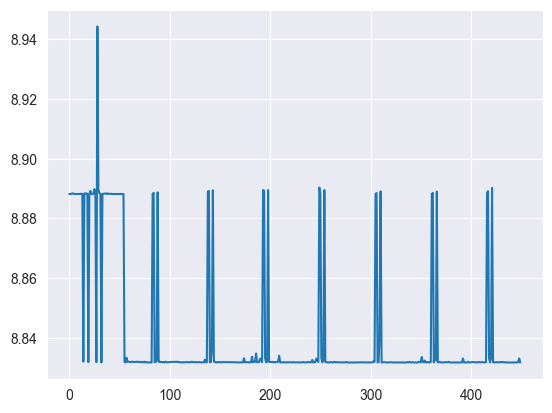

In [6]:
plt.plot(best_residuals)

In [7]:
final_residuals = extract_final_residuals()

Processing runs: 100%|██████████| 6312/6312 [00:00<00:00, 19280.58it/s]


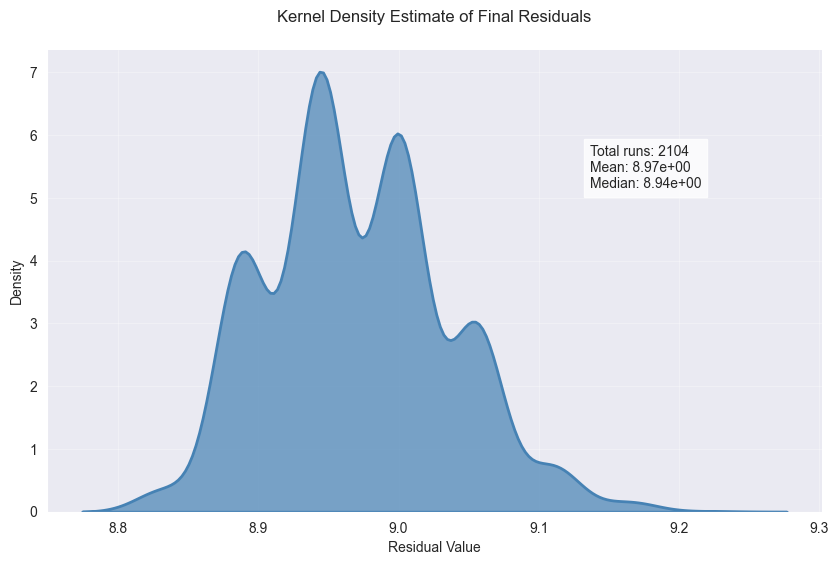

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(final_residuals,
                 bw_method=0.3,  # Bandwidth adjustment
                 fill=True,
                 color='#4682B4',
                 alpha=0.7,
                 linewidth=2)
stats_text = f"""Total runs: {len(final_residuals)}
Mean: {np.mean(final_residuals):.2e}
Median: {np.median(final_residuals):.2e}"""
plt.text(0.7, 0.7, stats_text,
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))
plt.title("Kernel Density Estimate of Final Residuals", pad=20)
plt.xlabel("Residual Value")
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
sns.despine()


In [30]:
def plot_kde_from_txt(file_path):
    values = []
    line_numbers = []

    with open(file_path, 'r') as file:
        for i, line in enumerate(file, start=1):
            stripped_line = line.strip()
            if stripped_line:  # Ignore empty lines
                value = float(stripped_line)
                values.append(value)
                line_numbers.append(i)

    # Find the record with the lowest value
    min_value = min(values)
    min_index = values.index(min_value)
    min_line = line_numbers[min_index]

    print(f"Lowest value: {min_value} found at line {min_line}")


    plt.figure(figsize=(10, 6))
    ax = sns.kdeplot(values,
                     bw_method=0.3,  # Bandwidth adjustment
                     fill=True,
                     color='#4682B4',
                     alpha=0.7,
                     linewidth=2)
    stats_text = f"""Total runs: 530
    Mean: {np.mean(values):.2e}
    Median: {np.median(values):.2e}"""
    plt.text(0.7, 0.7, stats_text,
         transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha=0.8))
    plt.title("Kernel Density Estimate of Final Residuals", pad=20)
    plt.xlabel("Residual Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    sns.despine()

Lowest value: 9.327377319335938 found at line 152


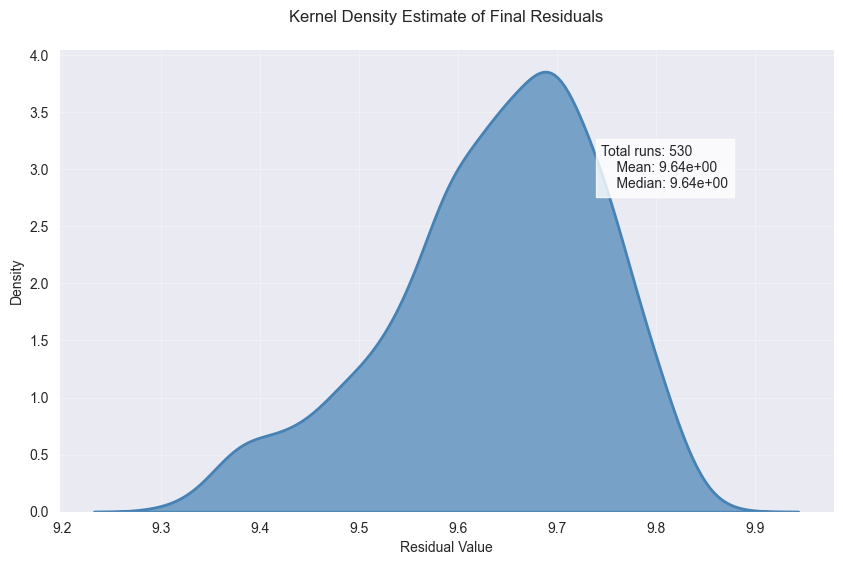

In [31]:
plot_kde_from_txt('trial_final_losses.txt')